In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')
sns.set_style(rc=plt.rcParams)

In [2]:
from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe
from loren_frank_data_processing import make_neuron_dataframe
from loren_frank_data_processing import get_position_dataframe
from loren_frank_data_processing import get_spikes_dataframe

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)

In [4]:
epoch_key = ('HPa', 3, 2) # animal, day, epoch
position_info = get_position_dataframe(epoch_key, ANIMALS)

Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [5]:
position_info['time_sec'] = position_info.index / np.timedelta64(1, 's')

In [6]:
neuron_info = make_neuron_dataframe(ANIMALS)
neuron_info = neuron_info.xs(epoch_key, drop_level=False)

In [7]:
def get_position_info_indices_at_spikes(spike_times_sec, position_info):
    '''
    spike_times_sec must be the times in seconds
    position_info must be modified to have a 'time_sec' column with corresponding units to spike_times_sec
    '''
    time_indices = np.empty((spike_times_sec.shape[0]), dtype='int')

    spike_time_index = 0

    for i, spike_time in enumerate(spike_times_sec):
        for index in range(spike_time_index, position_info['time_sec'].shape[0]):
            prev_index = max(0, index-1)
            prev_pos_time = position_info['time_sec'][prev_index]
            pos_time = position_info['time_sec'][index]
            # if we have gone too far
            if pos_time > spike_time:
                spike_time_index = prev_index
                break
        # time_ind (where to index into positions table)
        time_indices[i] = spike_time_index
    return time_indices

In [25]:
def get_firing_rates(spike_position_info, window_size_n = 15):
    '''
    This is for a dataframe with only one neuron
    '''
    firing_rates = np.empty(spike_position_info.shape[0])

    for i in range(spike_position_info.shape[0]):
        bottom = max(0, i+1-window_size_n)
        size = i+1 if bottom == 0 else window_size_n

        bottom_time = spike_position_info['time_sec'][bottom]
        current_time = spike_position_info['time_sec'][i]

        time_diff = current_time - bottom_time
        firing_rate = size / time_diff if size > 1 else 0

        firing_rates[i] = firing_rate
    return firing_rates

In [26]:
def get_combined_dataframe(neuron_info, position_info, window_size_n = 15):
    '''
    Combines all spikes from different neurons with associated position information
    
    Does some copying.
    '''
    # this happens on single core
    df = pd.DataFrame()

    for neuron_idx in range(neuron_info.index.shape[0]):
        neuron_area = neuron_info.iloc[neuron_idx]['area']
        neuron_id = neuron_info.iloc[neuron_idx]['neuron_id']

        spike_times = get_spikes_dataframe(neuron_info.index[neuron_idx], ANIMALS)
        spike_times_sec = spike_times.index / np.timedelta64(1, 's')
        time_indices = get_position_info_indices_at_spikes(spike_times_sec, position_info)

        spike_position_info = position_info.iloc[time_indices].copy()
        spike_position_info['neuron_idx'] = neuron_idx
        spike_position_info['neuron_area'] = neuron_area
        spike_position_info['neuron_id'] = neuron_id
        
        # technically inaccurate, but helps with frequency
        spike_position_info['time_sec'] = spike_times_sec
        
        spike_position_info['firing_rate'] = get_firing_rates(spike_position_info,
                                                              window_size_n=window_size_n)

        df = df.append(spike_position_info)
    return df


In [33]:
window_size_n = 15

combined_df = get_combined_dataframe(neuron_info, position_info, window_size_n = window_size_n)

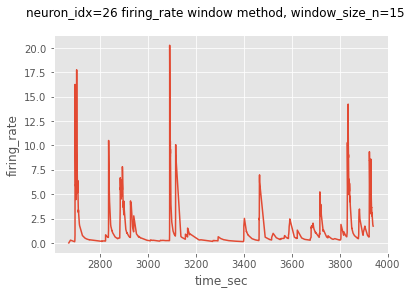

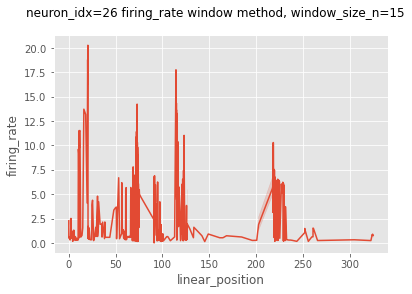

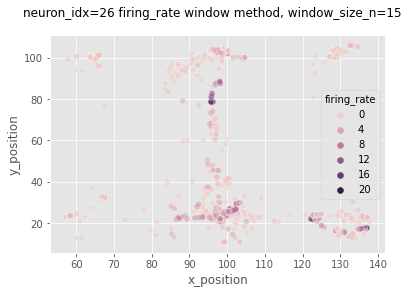

In [35]:
neuron_idx = 26

df = combined_df
df = df[df['neuron_idx'] == neuron_idx]

fig, ax = plt.subplots()
sns.lineplot(x='time_sec', y='firing_rate',
             data=df,
            ax=ax)
fig.suptitle(f'neuron_idx={neuron_idx} firing_rate window method, window_size_n={window_size_n}')
None

fig, ax = plt.subplots()
sns.lineplot(x='linear_position', y='firing_rate',
             data=df,
            ax=ax)
fig.suptitle(f'neuron_idx={neuron_idx} firing_rate window method, window_size_n={window_size_n}')
None

fig, ax = plt.subplots()
sns.scatterplot(x='x_position', y='y_position', hue='firing_rate',
                alpha=0.5,
             data=df,
            ax=ax)
fig.suptitle(f'neuron_idx={neuron_idx} firing_rate window method, window_size_n={window_size_n}')
None

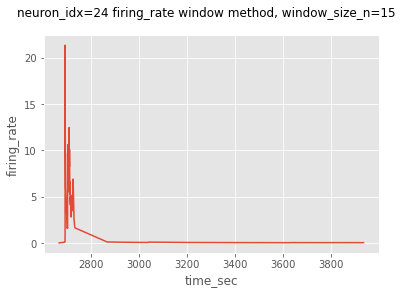

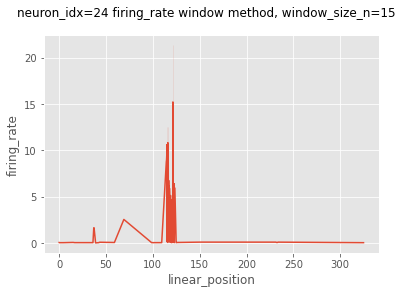

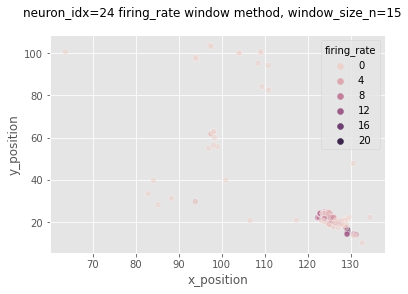

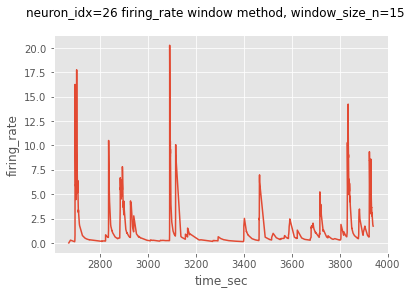

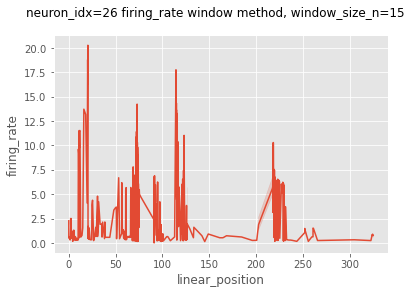

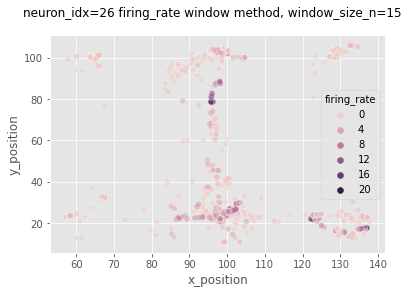

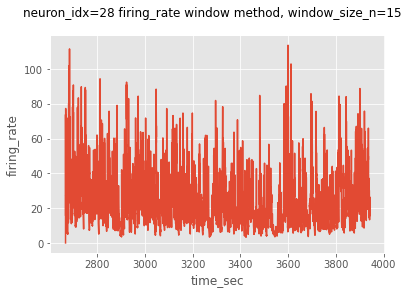

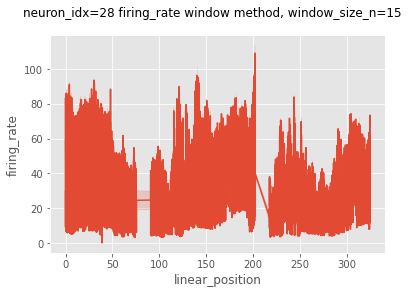

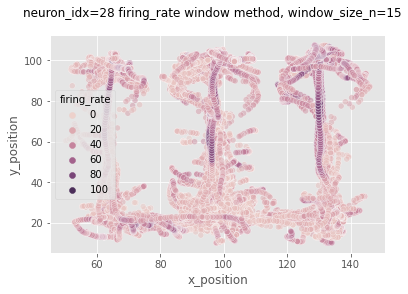

In [36]:
for neuron_idx in [24, 26, 28]:

    df = combined_df
    df = df[df['neuron_idx'] == neuron_idx]

    fig, ax = plt.subplots()
    sns.lineplot(x='time_sec', y='firing_rate',
                 data=df,
                ax=ax)
    fig.suptitle(f'neuron_idx={neuron_idx} firing_rate window method, window_size_n={window_size_n}')
    None

    fig, ax = plt.subplots()
    sns.lineplot(x='linear_position', y='firing_rate',
                 data=df,
                ax=ax)
    fig.suptitle(f'neuron_idx={neuron_idx} firing_rate window method, window_size_n={window_size_n}')
    None

    fig, ax = plt.subplots()
    sns.scatterplot(x='x_position', y='y_position', hue='firing_rate',
                    alpha=0.5,
                 data=df,
                ax=ax)
    fig.suptitle(f'neuron_idx={neuron_idx} firing_rate window method, window_size_n={window_size_n}')
    None

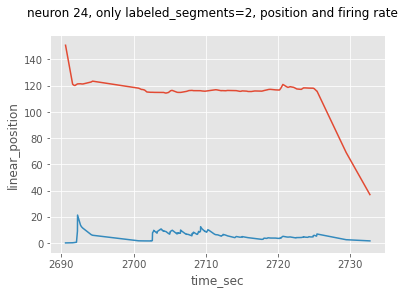

In [58]:
df = combined_df
df = df[df['neuron_idx'] == 24]
df = df[df['labeled_segments'] == 2]

fig, ax = plt.subplots()

sns.lineplot(x='time_sec', y='linear_position', data=df, ax=ax)
sns.lineplot(x='time_sec', y='firing_rate', data=df, ax=ax)

fig.suptitle('neuron 24, only labeled_segments=2, position and firing rate')
None

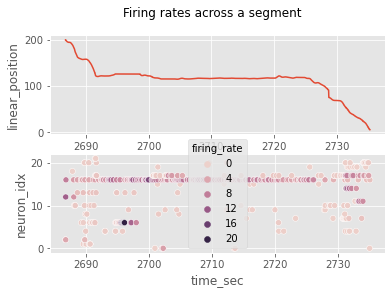

In [50]:
df = combined_df
df = df[df['labeled_segments'] == 2]

fig, ax = plt.subplots(nrows=2, ncols=1)

sns.lineplot(x='time_sec', y='linear_position', data=df,
            ax=ax[0])

sns.scatterplot(x='time_sec', y='neuron_idx', hue='firing_rate', data=df[df['neuron_area'] == 'CA1'],
               ax=ax[1])
fig.suptitle('Firing rates across a segment')
None

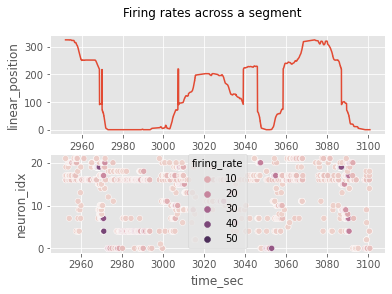

In [55]:
df = combined_df
df = df[(df['labeled_segments'] > 30) & (df['labeled_segments'] < 50)]

fig, ax = plt.subplots(nrows=2, ncols=1)

sns.lineplot(x='time_sec', y='linear_position', data=df,
            ax=ax[0])

sns.scatterplot(x='time_sec', y='neuron_idx', hue='firing_rate', data=df[df['neuron_area'] == 'CA1'],
               ax=ax[1])
fig.suptitle('Firing rates across a segment')
None